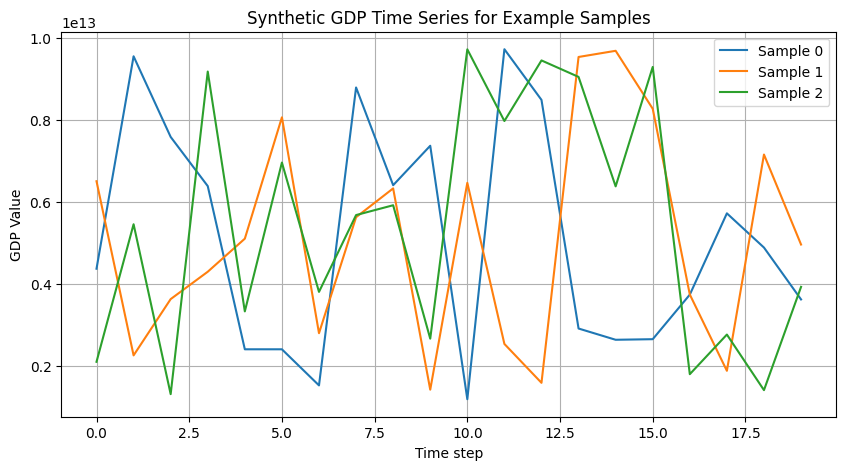

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

np.random.seed(42)
n_samples = 200
n_timesteps = 20
n_features = 1

gdp = np.random.uniform(1e12, 1e13, size=(n_samples, n_timesteps, n_features))
life_exp = 50 + (gdp.mean(axis=1).flatten() / 1e12) * 30 + np.random.normal(0, 2, size=n_samples)

sample_indices = [0, 1, 2]

plt.figure(figsize=(10, 5))
for idx in sample_indices:
    plt.plot(range(n_timesteps), gdp[idx,:,0], label=f"Sample {idx}")
plt.xlabel("Time step")
plt.ylabel("GDP Value")
plt.title("Synthetic GDP Time Series for Example Samples")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


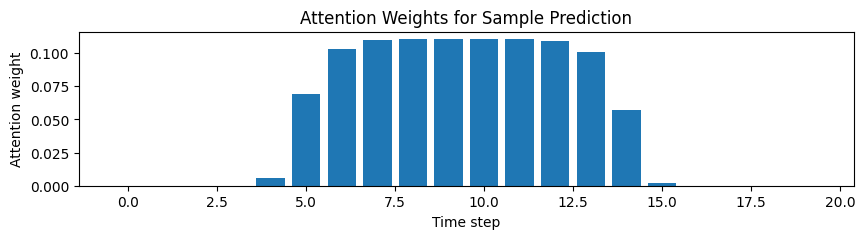

In [12]:
X_train, X_test, y_train, y_test = train_test_split(gdp, life_exp, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_flat = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_flat = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
X_train, X_test = X_train_flat, X_test_flat

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_w", shape=(input_shape[-1], input_shape[-1]),
                                 initializer="random_normal", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],),
                                 initializer="random_normal", trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1))
        scores = tf.tensordot(v, self.u, axes=1)
        weights = tf.nn.softmax(scores, axis=1)
        context = tf.reduce_sum(inputs * tf.expand_dims(weights, -1), axis=1)
        return context, weights

input_seq = Input(shape=(n_timesteps, n_features))
lstm_out = Bidirectional(LSTM(32, return_sequences=True))(input_seq)
context, att_weights = AttentionLayer()(lstm_out)
output = Dense(1)(context)
model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Create model for extracting attention weights
model_att = Model(inputs=input_seq, outputs=[output, att_weights])

# Get attention weights for a test sample
sample = X_test[0:1]
pred, weights = model_att.predict(sample)

# Plot attention weights
plt.figure(figsize=(10, 2))
plt.bar(range(n_timesteps), weights[0])
plt.xlabel("Time step")
plt.ylabel("Attention weight")
plt.title("Attention Weights for Sample Prediction")
plt.show()

